# Image multiclass classification with keras
The model used is a combinaison of Resnet (pre trained) and a fully connected network.

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline 
# import cv2
import sys
from IPython.display import display
from PIL import Image
sys.modules['Image'] = Image 
import PIL.Image
import os
PATH = os.getcwd()

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import preprocess_input
# from keras import regularizers

from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import Flatten
from tensorflow.python.keras.layers import Activation
from tensorflow.python.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels

Using TensorFlow backend.


## Defining the database

In [2]:
img_width, img_height = 224, 224

resnet_weights_path = '../weights/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
top_model_weights_path = '../weights/bottleneck_fc_model.h5'

train_data_dir = 'train_data_folder'
validation_data_dir = 'validation_data_folder'

nb_train_samples = 0
for root, dirs, files in os.walk(train_data_dir):
    nb_train_samples += len(files)
print('train samples :', nb_train_samples)

nb_validation_samples = 0
for root, dirs, files in os.walk(validation_data_dir):
    nb_validation_samples += len(files)
print('validation samples :', nb_validation_samples)

train samples : 1835
validation samples : 80


## To remove unwanted jupyter notebook checkpoints in your data folder

In [ ]:
#REMOVING NOTEBOOK CHECKPOINTS IN DATA FOLDER
% cd path_to_your_data
!find . -name .ipynb_checkpoints -exec rm -rf {} \;

## Calculating the output of the resnet model
This allows for faster training of the classifier which comes after

In [3]:
resnet = ResNet50(weights = resnet_weights_path, include_top = False)
# model.summary()

Instructions for updating:
Colocations handled automatically by placer.


/opt/conda/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [12]:
def save_bottleneck_train_features():

    train_datagen = ImageDataGenerator( #rescale=1.0/255.0,
                                    samplewise_center=False, 
                                    samplewise_std_normalization=False, 
                                    horizontal_flip = True, 
                                    vertical_flip = True, 
                                    height_shift_range = 0.1, 
                                    width_shift_range = 0.1, 
                                    rotation_range = 2, 
                                    shear_range = 0,
                                    fill_mode = 'constant',
                                    zoom_range = 0.2,
                                    preprocessing_function = preprocess_input)
    
    
    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size = (img_width, img_height),
        batch_size = 3000,
        class_mode = 'categorical',
        shuffle = True)
    
    batch = next(train_generator) #initialization
    bottleneck_features_train = resnet.predict(batch[0], verbose=True)
    bottleneck_labels_train = batch[1]
    
    for i in range(2):
        batch = next(train_generator)
        next_pred = resnet.predict(batch[0], verbose=False)
        bottleneck_features_train = np.concatenate((bottleneck_features_train, next_pred))
        next_label = batch[1]
        bottleneck_labels_train = np.concatenate((bottleneck_labels_train, next_label))
        
    np.save(open('bottleneck_features_train.npy', 'wb'), bottleneck_features_train)
    np.save(open('bottleneck_labels_train.npy', 'wb'), bottleneck_labels_train)
    

def save_bottleneck_validation_features():

    test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
    
    test_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size = (img_width, img_height),
        batch_size = nb_validation_samples,
        class_mode = 'categorical',
        shuffle = False)
    
    
    batch = next(test_generator) #initialization
    bottleneck_features_validation = resnet.predict(batch[0], verbose=True)
    bottleneck_label_validation = batch[1]
    
    np.save(open('bottleneck_features_validation.npy', 'wb'), bottleneck_features_validation)
    np.save(open('bottleneck_labels_validation.npy', 'wb'), bottleneck_label_validation)

In [13]:
save_bottleneck_train_features()
save_bottleneck_validation_features()

Found 1833 images belonging to 12 classes.
1833/1833 [==============================] - 4s 2ms/sample
Found 80 images belonging to 12 classes.
80/80 [==============================] - 0s 2ms/sample


## Training the classifier using the previous resnet output

In [9]:
    # Fully connected network architecture

top_model = Sequential()
top_model.add(Dropout(0.7))
top_model.add(Flatten())
top_model.add(Dense(2048, activation='linear',name='fc-2'))
# top_model.add(Dropout(0.3))
top_model.add(Activation('relu'))
top_model.add(Dense(1024, activation='linear',name='fc-3'))
# top_model.add(Dropout(0.2))
top_model.add(Activation('relu'))
top_model.add(Dense(512, activation='linear',name='fc-4'))
# top_model.add(Dropout(0.2))
top_model.add(Activation('relu'))
top_model.add(Dense(256, activation='linear',name='fc-5'))
# top_model.add(Dropout(0.2))
top_model.add(Activation('relu'))
top_model.add(Dense(12, activation='softmax',name='output_layer'))


adam = Adam(lr = 0.0001, decay=0.0001)
top_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [10]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 20)
cb_checkpointer = ModelCheckpoint(filepath = '../weights/bottleneck_fc_model.h5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [11]:

# Training the top model

train_data = np.load(open('bottleneck_features_train.npy', 'rb'))
train_labels = np.load(open('bottleneck_labels_train.npy', 'rb'))

validation_data = np.load(open('bottleneck_features_validation.npy', 'rb'))
validation_labels = np.load(open('bottleneck_labels_validation.npy', 'rb'))

fit_history = top_model.fit(train_data, train_labels,
          epochs = 999,
          batch_size = 64,
          validation_data=(validation_data, validation_labels),
          callbacks = [cb_checkpointer, cb_early_stopper],
          verbose = True)

top_model.load_weights("../weights/bottleneck_fc_model.h5")
    

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 1833 samples, validate on 80 samples
Epoch 1/999
1833/1833 [==============================] - 27s 15ms/sample - loss: 2.0009 - categorical_accuracy: 0.4163 - val_loss: 1.2921 - val_categorical_accuracy: 0.5750
Epoch 2/999
1833/1833 [==============================] - 25s 14ms/sample - loss: 0.6503 - categorical_accuracy: 0.7867 - val_loss: 1.2789 - val_categorical_accuracy: 0.6000
Epoch 3/999
1833/1833 [==============================] - 2s 1ms/sample - loss: 0.2495 - categorical_accuracy: 0.9220 - val_loss: 1.2944 - val_categorical_accuracy: 0.6750
Epoch 4/999
1833/1833 [==============================] - 2s 1ms/sample - loss: 0.1319 - categorical_accuracy: 0.9569 - val_loss: 1.4317 - val_categorical_accuracy: 0.6125
Epoch 5/999
1833/1833 [==============================] - 2s 1ms/sample - loss: 0.0695 - categorical_accuracy: 0.9787 - val_loss: 1.5256 - val_categoric

## Ploting the training results

In [ ]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['categorical_accuracy'])  
plt.plot(fit_history.history['val_categorical_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()
plt.savefig('../figures/training_99_dropout.png', bbox_inches='tight')


In [13]:
y_pred_full = top_model.predict(validation_data, verbose = True)
y_pred_percent = (np.array(y_pred_full) * 100).astype(int)
y_pred_top = np.argmax(y_pred_full, axis=1)
y_real = np.argmax(validation_labels, axis=1)

display_datagen = ImageDataGenerator(rescale=1.0/255.0)

display_generator = display_datagen.flow_from_directory( #same as dev/test set but without preprocessing to be able to display the pictures with normal colors
        'validation_data_folder',
        target_size = (img_width, img_height),
        batch_size = nb_validation_samples,
        class_mode = 'categorical',
        shuffle = False)

images, _ = next(display_generator)

class_names = sorted(os.listdir(train_data_dir)) # Flow from directory sorts classes in alphabetical order

80/80 [==============================] - 0s 2ms/sample
Found 79 images belonging to 12 classes.


## Creating a confusion matrix

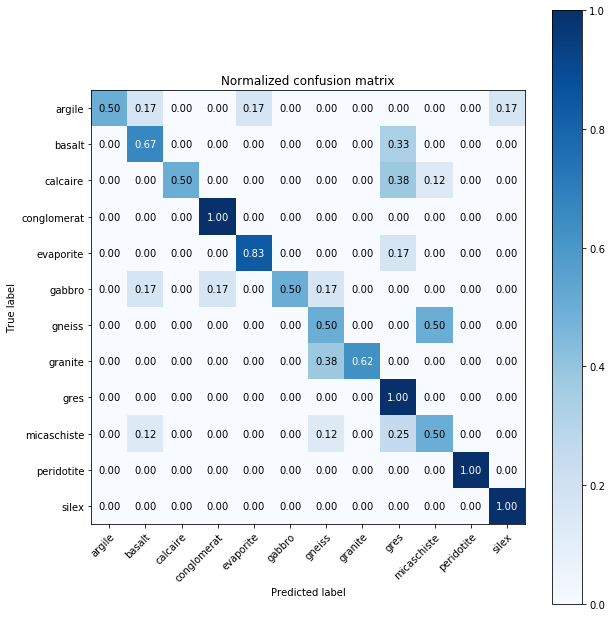

In [14]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          save_fig = False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots(figsize = (9,9))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    if save_fig:
        fig.savefig('../figures/confusion_matrix.png', bbox_inches='tight')
    
    return ax

plot_confusion_matrix(y_real, y_pred_top, classes=class_names, normalize=True, save_fig = True)




## Displaying the prediction results on the validation set

In [ ]:
fig, axs = plt.subplots(nb_validation_samples // 5, 5, figsize=(20, 1.2 * nb_validation_samples)) #Warning: better to have number of sample divisible by 5
axs = axs.flatten()
plt.subplots_adjust(hspace=0, wspace = 0)

i = 0
for img, ax in zip(images, axs):
    ax.axis("off")

    top3_predictions = sorted(zip(y_pred_percent[i], class_names), reverse=True)[:3]
    legend = (top3_predictions[0][1] + " : " + str(top3_predictions[0][0]) + "%" + "\n"
            + top3_predictions[1][1] + " : " + str(top3_predictions[1][0]) + "%" + "\n"
            + top3_predictions[2][1] + " : " + str(top3_predictions[2][0]) + "%")   
    
    if y_pred_top[i] != y_real[i]:
        ax.set_title(legend + "\n real : " + class_names[y_real[i]], color='r')
    else:
        ax.set_title(legend, color = 'g')
        
    i += 1
    
    ax.imshow(img)
    
# plt.savefig('../figures/all_classes_77.png', bbox_inches='tight')
